In [1]:
# @title
### EP2 MAC0417 / MAC5768 ##################################################
#  AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,              #
#  DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELAS RESPOSTAS NESTA LISTA.    #
#  TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM, SEGUINDO AS    #
#  INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM DESONESTIDADE ACADÊMICA OU PLÁGIO.#
#                                                                              #
#  DECLARO TAMBÉM QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS                      #
#  DESSE PROGRAMA E QUE EU NÃO DISTRIBUI OU FACILITEI A                        #
#  SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E                     #
#  DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS                 #
#  DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                                        #
#  ENTENDO QUE LISTAS SEM ASSINATURA NÃO SERÃO CORRIGIDAS E,                   #
#  AINDA ASSIM, PODERÃO SER PUNIDOS POR DESONESTIDADE ACADÊMICA.               #
#                                                                              #
#  Nome : Érico Tiago Meireles                                                 #
#  NUSP : 9312428                                                              #
#  Turma: MAC5768 Visão e Processamento de Imagens                             #
#  Prof.: Ronaldo Fumio Hashimoto                                              #
################################################################################

## EP2 - Normalização e Análises

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import cv2

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

#### Importa os metadados

In [3]:
metadata = pd.read_csv(rf"../metadados.csv", sep=';')

#### Criação da tabela sumária geral:

In [4]:
# Define uma nova coluna "classe" para agrupar todas as classes presentes em cada imagem

metadata['classe'] = metadata['classe_1']

for i in range(2, 6):
    metadata['classe'] += ', ' + metadata.apply(lambda row: row['classe_' + str(i)] if pd.notnull(row['classe_' + str(i)]) else '', axis=1)

# Remove ',' no final do string
metadata['classe'] = metadata['classe'].str.rstrip(', ')

In [5]:
# Separa as palavras por vírgula e cria uma lista única de palavras
palavras_unicas = set(palavra.strip() for palavra in ','.join(metadata['classe']).split(',') if palavra)
# Converte o conjunto de volta para uma lista
lista_palavras_unicas = list(palavras_unicas)

In [6]:

def get_folder_size(path):
    # Define o tamanho de uma pasta

    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)  # Converte bytes para megabytes

# retorna tamanho em MB das fotos reescaladas
tamanho_mb = get_folder_size("../data_resized/")

In [7]:
def get_image_resolutions(path):

    # pega a resolução das imagens no diretório de interesse
    resolutions = []
    for filename in os.listdir(path):
        if filename.lower().endswith('.jpeg'):  # Exemplo para imagens PNG
            image_path = os.path.join(path, filename)
            image = plt.imread(image_path)
            resolutions.append(image.shape[:2])  # (linhas, colunas)
    return pd.DataFrame(resolutions, columns=['Linhas', 'Colunas'])

# Obtem a resolução média (linhas x Colunas)
resolucoes_df = get_image_resolutions("../data_resized/")
linhas = (sum(resolucoes_df['Linhas'])/len(resolucoes_df['Linhas']))
colunas = (sum(resolucoes_df['Colunas'])/len(resolucoes_df['Colunas']))

##### TABELA SUMÁRIA

In [8]:
print(
    f'''
#############################################
    
Tabela Global sumária:
    > Nome das classes: {lista_palavras_unicas}
    > Número das classes: {len(lista_palavras_unicas)}
    > Número de imagens: {len(metadata)}
    > Tamanho da base: {round(tamanho_mb, 2)} MB
    > Resolução das imagens: {round(linhas, 0)} linhas X {round(colunas, 0)} colunas
    
#############################################
'''
)


#############################################
    
Tabela Global sumária:
    > Nome das classes: ['livro', 'som', 'caneta', 'pilha', 'faca', 'colher', 'capacete', 'caneca', 'protetor solar', 'garfo']
    > Número das classes: 10
    > Número de imagens: 109
    > Tamanho da base: 5.38 MB
    > Resolução das imagens: 600.0 linhas X 800.0 colunas
    
#############################################



#### Criação da Tabela Detalhada por Classe 

In [9]:
resumos = []

# Iterando pelas palavras únicas
for classe in lista_palavras_unicas:
    # Filtrando o dataframe para linhas que contêm a classe
    filtered_df = metadata[metadata['classe'].str.contains(classe, na=False)]

    # Contando a quantidade de cada objeto por foto
    # Inicializando listas para armazenar as contagens
    counts = []
    
    # Splitando a coluna "classe" para contar a quantidade de cada objeto por foto
    counts = filtered_df['classe'].str.split(', ')
    counts = counts.apply(lambda x: len(x))
    
    
    # Calculando a quantidade mínima e máxima de objetos por foto
    min_count = min(counts)
    max_count = max(counts)
    
    # Verificando as variações de fundo e iluminação
    fundos = filtered_df['fundo'].unique()
    iluminacoes = filtered_df['iluminacao'].unique()
    
    # Calculando o número total de fotos e repetições
    total_fotos = len(filtered_df)

    # Calculando as repetições para cada fundo e cada iluminação
    repeticoes_fundos = filtered_df.groupby('fundo')['classe'].apply(lambda x: x.str.count(classe).sum()).to_dict()
    repeticoes_iluminacoes = filtered_df.groupby('iluminacao')['classe'].apply(lambda x: x.str.count(classe).sum()).to_dict()
    
    # Criando o resumo e adicionando à lista
    resumo = {
        'Objeto': classe,
        'Min_Objetos': min_count,
        'Max_Objetos': max_count,
        'Variações_Fundo': len(fundos),
        'Fundos': ', '.join(fundos),
        'Repetições_Fundos': repeticoes_fundos,
        'Variações_Iluminação': len(iluminacoes),
        'Iluminações': ', '.join(iluminacoes),
        'Repetições_Iluminações': repeticoes_iluminacoes,
        'Total_Fotos': len(filtered_df)
    }
    resumos.append(resumo)
# Criando o dataframe de resumo
df_resumo = pd.DataFrame(resumos)

##### TABELA DETALHADA POR CLASSE

In [10]:
df_resumo

,Objeto,Min_Objetos,Max_Objetos,Variações_Fundo,Fundos,Repetições_Fundos,Variações_Iluminação,Iluminações,Repetições_Iluminações,Total_Fotos
0,livro,3,5,4,"sofa, chao, preto, varanda","{'chao': 8, 'preto': 14, 'sofa': 10, 'varanda': 9}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 8, 'externo-escuro': 12, 'interno-claro': 10, 'interno-escuro': 11}",41
1,som,3,5,4,"sofa, chao, varanda, preto","{'chao': 10, 'preto': 10, 'sofa': 14, 'varanda': 8}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 5, 'externo-escuro': 17, 'interno-claro': 10, 'interno-escuro': 10}",42
2,caneta,3,5,4,"chao, sofa, varanda, preto","{'chao': 13, 'preto': 20, 'sofa': 7, 'varanda': 11}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 15, 'externo-escuro': 15, 'interno-claro': 13, 'interno-escuro': 8}",51
3,pilha,3,5,4,"sofa, chao, varanda, preto","{'chao': 11, 'preto': 12, 'sofa': 11, 'varanda': 11}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 9, 'externo-escuro': 12, 'interno-claro': 12, 'interno-escuro': 12}",45
4,faca,3,5,4,"sofa, preto, chao, varanda","{'chao': 11, 'preto': 12, 'sofa': 11, 'varanda': 11}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 11, 'externo-escuro': 15, 'interno-claro': 9, 'interno-escuro': 10}",45
5,colher,3,5,4,"sofa, chao, preto, varanda","{'chao': 13, 'preto': 12, 'sofa': 14, 'varanda': 7}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 10, 'externo-escuro': 13, 'interno-claro': 12, 'interno-escuro': 11}",46
6,capacete,3,5,4,"sofa, chao, preto, varanda","{'chao': 7, 'preto': 10, 'sofa': 9, 'varanda': 9}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 6, 'externo-escuro': 13, 'interno-claro': 11, 'interno-escuro': 5}",35
7,caneca,3,5,4,"sofa, chao, preto, varanda","{'chao': 10, 'preto': 10, 'sofa': 10, 'varanda': 12}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 10, 'externo-escuro': 14, 'interno-claro': 8, 'interno-escuro': 10}",42
8,protetor solar,3,5,4,"preto, sofa, chao, varanda","{'chao': 11, 'preto': 9, 'sofa': 7, 'varanda': 12}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 6, 'externo-escuro': 10, 'interno-claro': 13, 'interno-escuro': 10}",39
9,garfo,3,5,4,"sofa, preto, varanda, chao","{'chao': 9, 'preto': 17, 'sofa': 8, 'varanda': 8}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 8, 'externo-escuro': 9, 'interno-claro': 11, 'interno-escuro': 14}",42


### Normaliza o histograma:

In [11]:

# Função para normalizar o histograma
def normalize_histogram(img):
    img_flat = img.flatten()
    hist, bins = np.histogram(img_flat, bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * (hist.max() / cdf.max())
    cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf = cdf.astype('uint8')
    img_normalized = cdf[img_flat]
    return img_normalized.reshape(img.shape)

In [12]:
# Caminho para o diretório das imagens em tons de cinza
original_gray_dir = "../data_EP2/originalGrayDataset/"

# Caminho para o diretório das imagens para normalized dataset
normalized_img_dir = "../data_EP2/normalizedDataset/"


augmented_dir = "../data_EP2/augmentedDataset/"

# Criando o diretório para as imagens redimensionadas se ele não existir
if not os.path.exists(normalized_img_dir):
    os.makedirs(normalized_img_dir)

In [13]:
# Lista de nomes de arquivos das imagens originais
img_names = os.listdir(original_gray_dir)

for img_name in img_names:
    img_path_original = os.path.join(original_gray_dir, img_name)
    img_path_normalized = os.path.join(normalized_img_dir, img_name)
    
    # Carregando a imagem original em tons de cinza
    if os.path.exists(img_path_original):
        img_gray = cv2.imread(img_path_original)
        
        # Normaliazando o histograma
        img_normalized = normalize_histogram(img_gray)
        
        # Salvando a imagem processada
        cv2.imwrite(img_path_normalized, img_normalized.astype(np.uint8))

print("Imagens processadas e salvas com sucesso!")

Imagens processadas e salvas com sucesso!


### Histograma por iluminação:

In [14]:


# Subdiretórios para diferentes processamentos
# Obter subdiretórios de forma dinâmica
processings = [d for d in os.listdir(augmented_dir) if os.path.isdir(os.path.join(augmented_dir, d))]


In [15]:
# Função para calcular o histograma de uma imagem
def calculate_histogram(img):
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])
    return hist

# Função para calcular o histograma médio para um conjunto de imagens
def calculate_average_histogram(image_paths):
    histograms = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        hist = calculate_histogram(img)
        histograms.append(hist)
    average_hist = np.mean(histograms, axis=0)
    return average_hist


# Função para plotar histogramas
def plot_avg_histograms(histograms, title):
    plt.figure(figsize=(10, 5))
    for label, hist in histograms.items():
        plt.plot(hist, label=label)
    plt.title(title)
    plt.xlabel('Intensidade de Pixels')
    plt.ylabel('Frequência')
    plt.legend()
    plt.show()


# Função para plotar histogramas
def plot_histograms(histograms, title):
    plt.figure(figsize=(10, 5))
    for label, hist in histograms.items():
        plt.hist(hist, label=label, bins=256, range=(0, 255))
        plt.title(title)
        plt.xlabel('Intensidade de Pixels')
        plt.ylabel('Frequência')
        plt.legend()
        plt.show()

In [16]:
def plt_img_hist(img_array, titulo):

  # Achatar a imagem em tons de cinza para 1D
  img_flat = img_array.flatten()

  # Plot do histogram de intensidade
  plt.hist(img_flat, bins=256, range=(0, 255), alpha=0.7)
  plt.title(titulo)
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')
  plt.ylim(0, 30000)
  plt.show()

In [31]:
# Selecionando aleatoriamente um conjunto de imagens
np.random.seed(42)  # Definindo a semente aleatória para reprodução
sample_imgs = metadata['img'].sample(1, replace=True)  # Selecionando 3 imagens aleatórias do dataframe

# Carregando e plotando as imagens usando a função plot_sample
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def tile(imgs, n=6):
    return np.vstack([np.hstack(img_chunk) for img_chunk in chunks(imgs, n)])

def plot_sample(x, titulo):
    nrows = int(np.sqrt(len(x)) + 0.5)
    ncols = len(x) // nrows + (1 if len(x) % nrows != 0 else 0)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(tile(x, ncols),cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title(titulo)
    plt.show()

In [34]:
# Coletar os histogramas médios
histograms_original = {}
histograms_normalized = {}
for iluminacao in metadata['iluminacao'].unique():
    image_paths = metadata[metadata['iluminacao'] == iluminacao]['img'].apply(lambda x: os.path.join(original_gray_dir, x)).tolist()
    figuras = [cv2.imread(os.path.join(original_gray_dir, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(original_gray_dir, img_name))]
    print(figuras)
    figuras_norm = [cv2.imread(os.path.join(normalized_img_dir, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(normalized_img_dir, img_name))]
    figuras = figuras.append(figuras_norm)
    print(figuras)
    plot_sample(figuras,  f'Fotos Normalizadas - {iluminacao.capitalize()}')
    image_norm_paths = metadata[metadata['iluminacao'] == iluminacao]['img'].apply(lambda x: os.path.join(normalized_img_dir, x)).tolist()
    average_hist = calculate_average_histogram(image_paths)
    histograms_original[iluminacao] = average_hist

    average_hist_norm = calculate_average_histogram(image_norm_paths)
    histograms_normalized[iluminacao] = average_hist_norm

    
# Plotar histogramas médios separados por iluminação para o conjunto original
# for iluminacao, hist in histograms_original.items():
#     plt.figure(figsize=(10, 5))
#     plt.hist(hist, bins=256)
#     plt.title(f'Histograma Médio - Original ({iluminacao})')
#     plt.xlabel('Intensidade de Pixels')
#     plt.ylabel('Frequência')
#     plt.ylim(0,10)
#     plt.show()



# Plotar histogramas médios antes e depois da normalização
plot_avg_histograms(histograms_original, 'Histogramas Médios - Original')

plot_avg_histograms(histograms_normalized, 'Histogramas Médios - Normalizado')



[array([[[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [251, 251, 251],
        [250, 250, 250],
        [250, 250, 250]],

       [[ 51,  51,  51],
        [ 51,  51,  51],
        [ 51,  51,  51],
        ...,
        [ 31,  31,  31],
        [ 30,  30,  30],
        [ 30,  30,  30]],

       [[ 50,  50,  50],
        [ 50,  50,  50],
        [ 50,  50,  50],
        ...,
        [ 34,  34,  34],
        [ 33,  33,  33],
        [ 33,  33,  33]],

       ...,

       [[ 43,  43,  43],
        [ 43,  43,  43],
        [ 44,  44,  44],
        ...,
        [ 36,  36,  36],
        [ 35,  35,  35],
        [ 35,  35,  35]],

       [[ 45,  45,  45],
        [ 45,  45,  45],
        [ 46,  46,  46],
        ...,
        [ 32,  32,  32],
        [ 31,  31,  31],
        [ 31,  31,  31]],

       [[250, 250, 250],
        [250, 250, 250],
        [250, 250, 250],
        ...,
        [251, 251, 251],
        [251, 251, 251],
        [251, 251, 251]

TypeError: object of type 'NoneType' has no len()

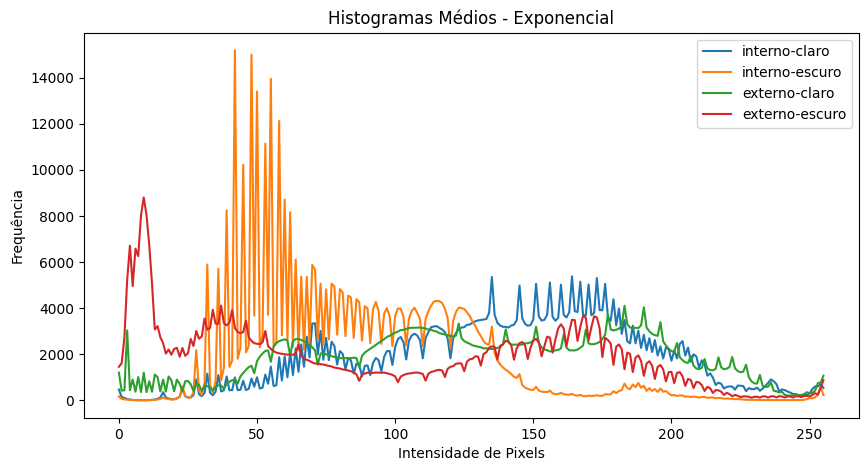

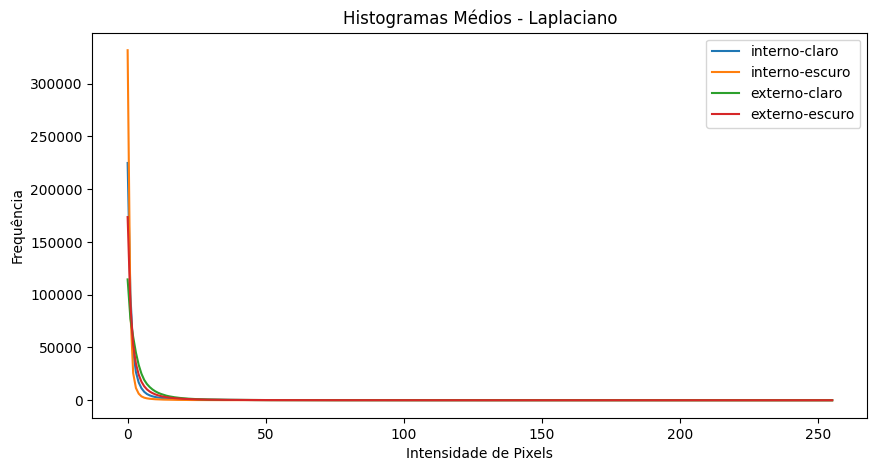

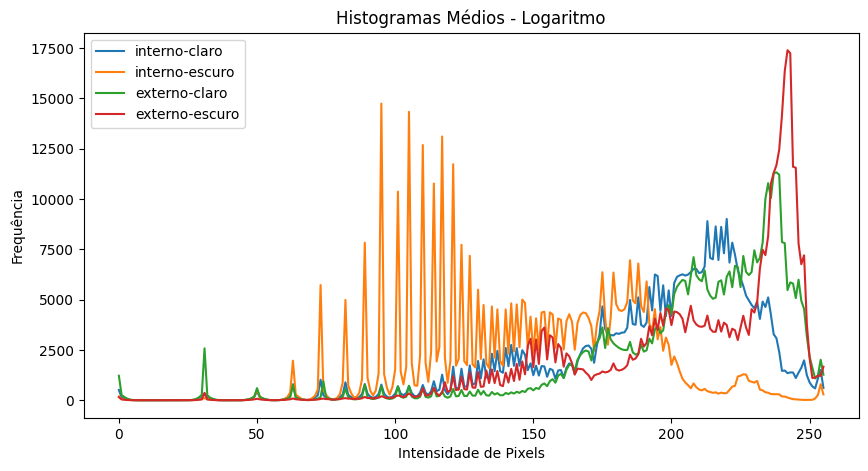

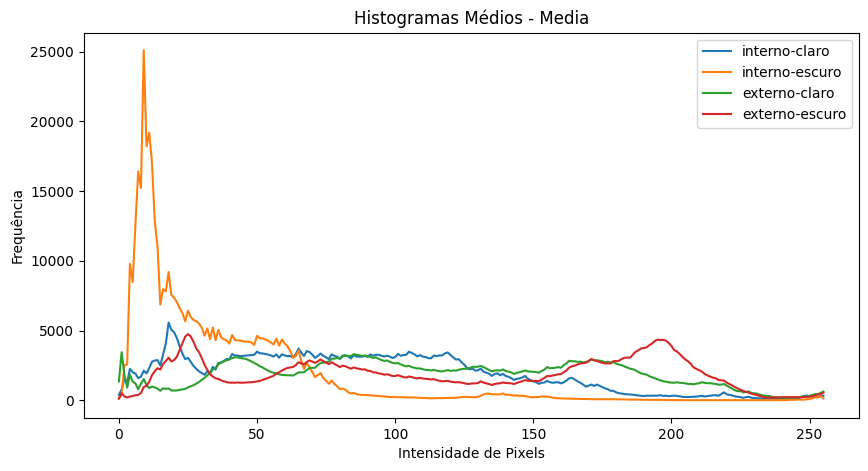

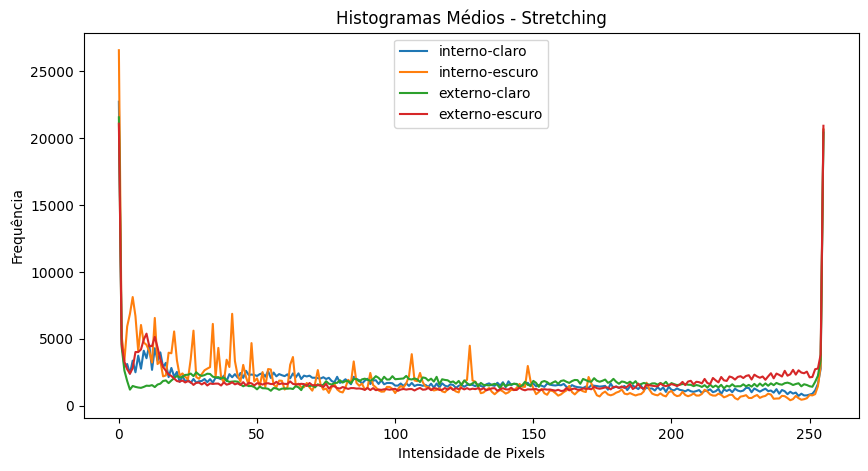

In [22]:

# Coletar e plotar histogramas para cada processamento
for processing in processings:
    histograms_original = {}
    histograms_normalized = {}
    for iluminacao in metadata['iluminacao'].unique():
        image_paths = metadata[metadata['iluminacao'] == iluminacao]['img'].apply(lambda x: os.path.join(augmented_dir, processing, x)).tolist()
        average_hist = calculate_average_histogram(image_paths)
        histograms_original[iluminacao] = average_hist
    
    plot_avg_histograms(histograms_original, f'Histogramas Médios - {processing.capitalize()}')